C:\Users\drewr\AppData\Local\Temp\ipykernel_8648\1237342832.py:362: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['volume_pct'] = df['volume_usd'].rolling(30).apply(lambda x: percentileofscore(x, x[-1]))
C:\Users\drewr\AppData\Local\Temp\ipykernel_8648\1237342832.py:363: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['atr_pct'] = df['ATR'].rolling(30).apply(lambda x: percentileofscore(x, x[-1]))
2025-02-10 18:22:31,659 - INFO - 
=== Signal Check at 2022-05-18 00:00:00+00:00 ===
2025-02-10 18:22:31,661 - INFO - Current Price: 28715.32
2025-02-10 18:22:31,662 - INFO - Market Score Breakdown:
2025-02-10 18:22:31,66

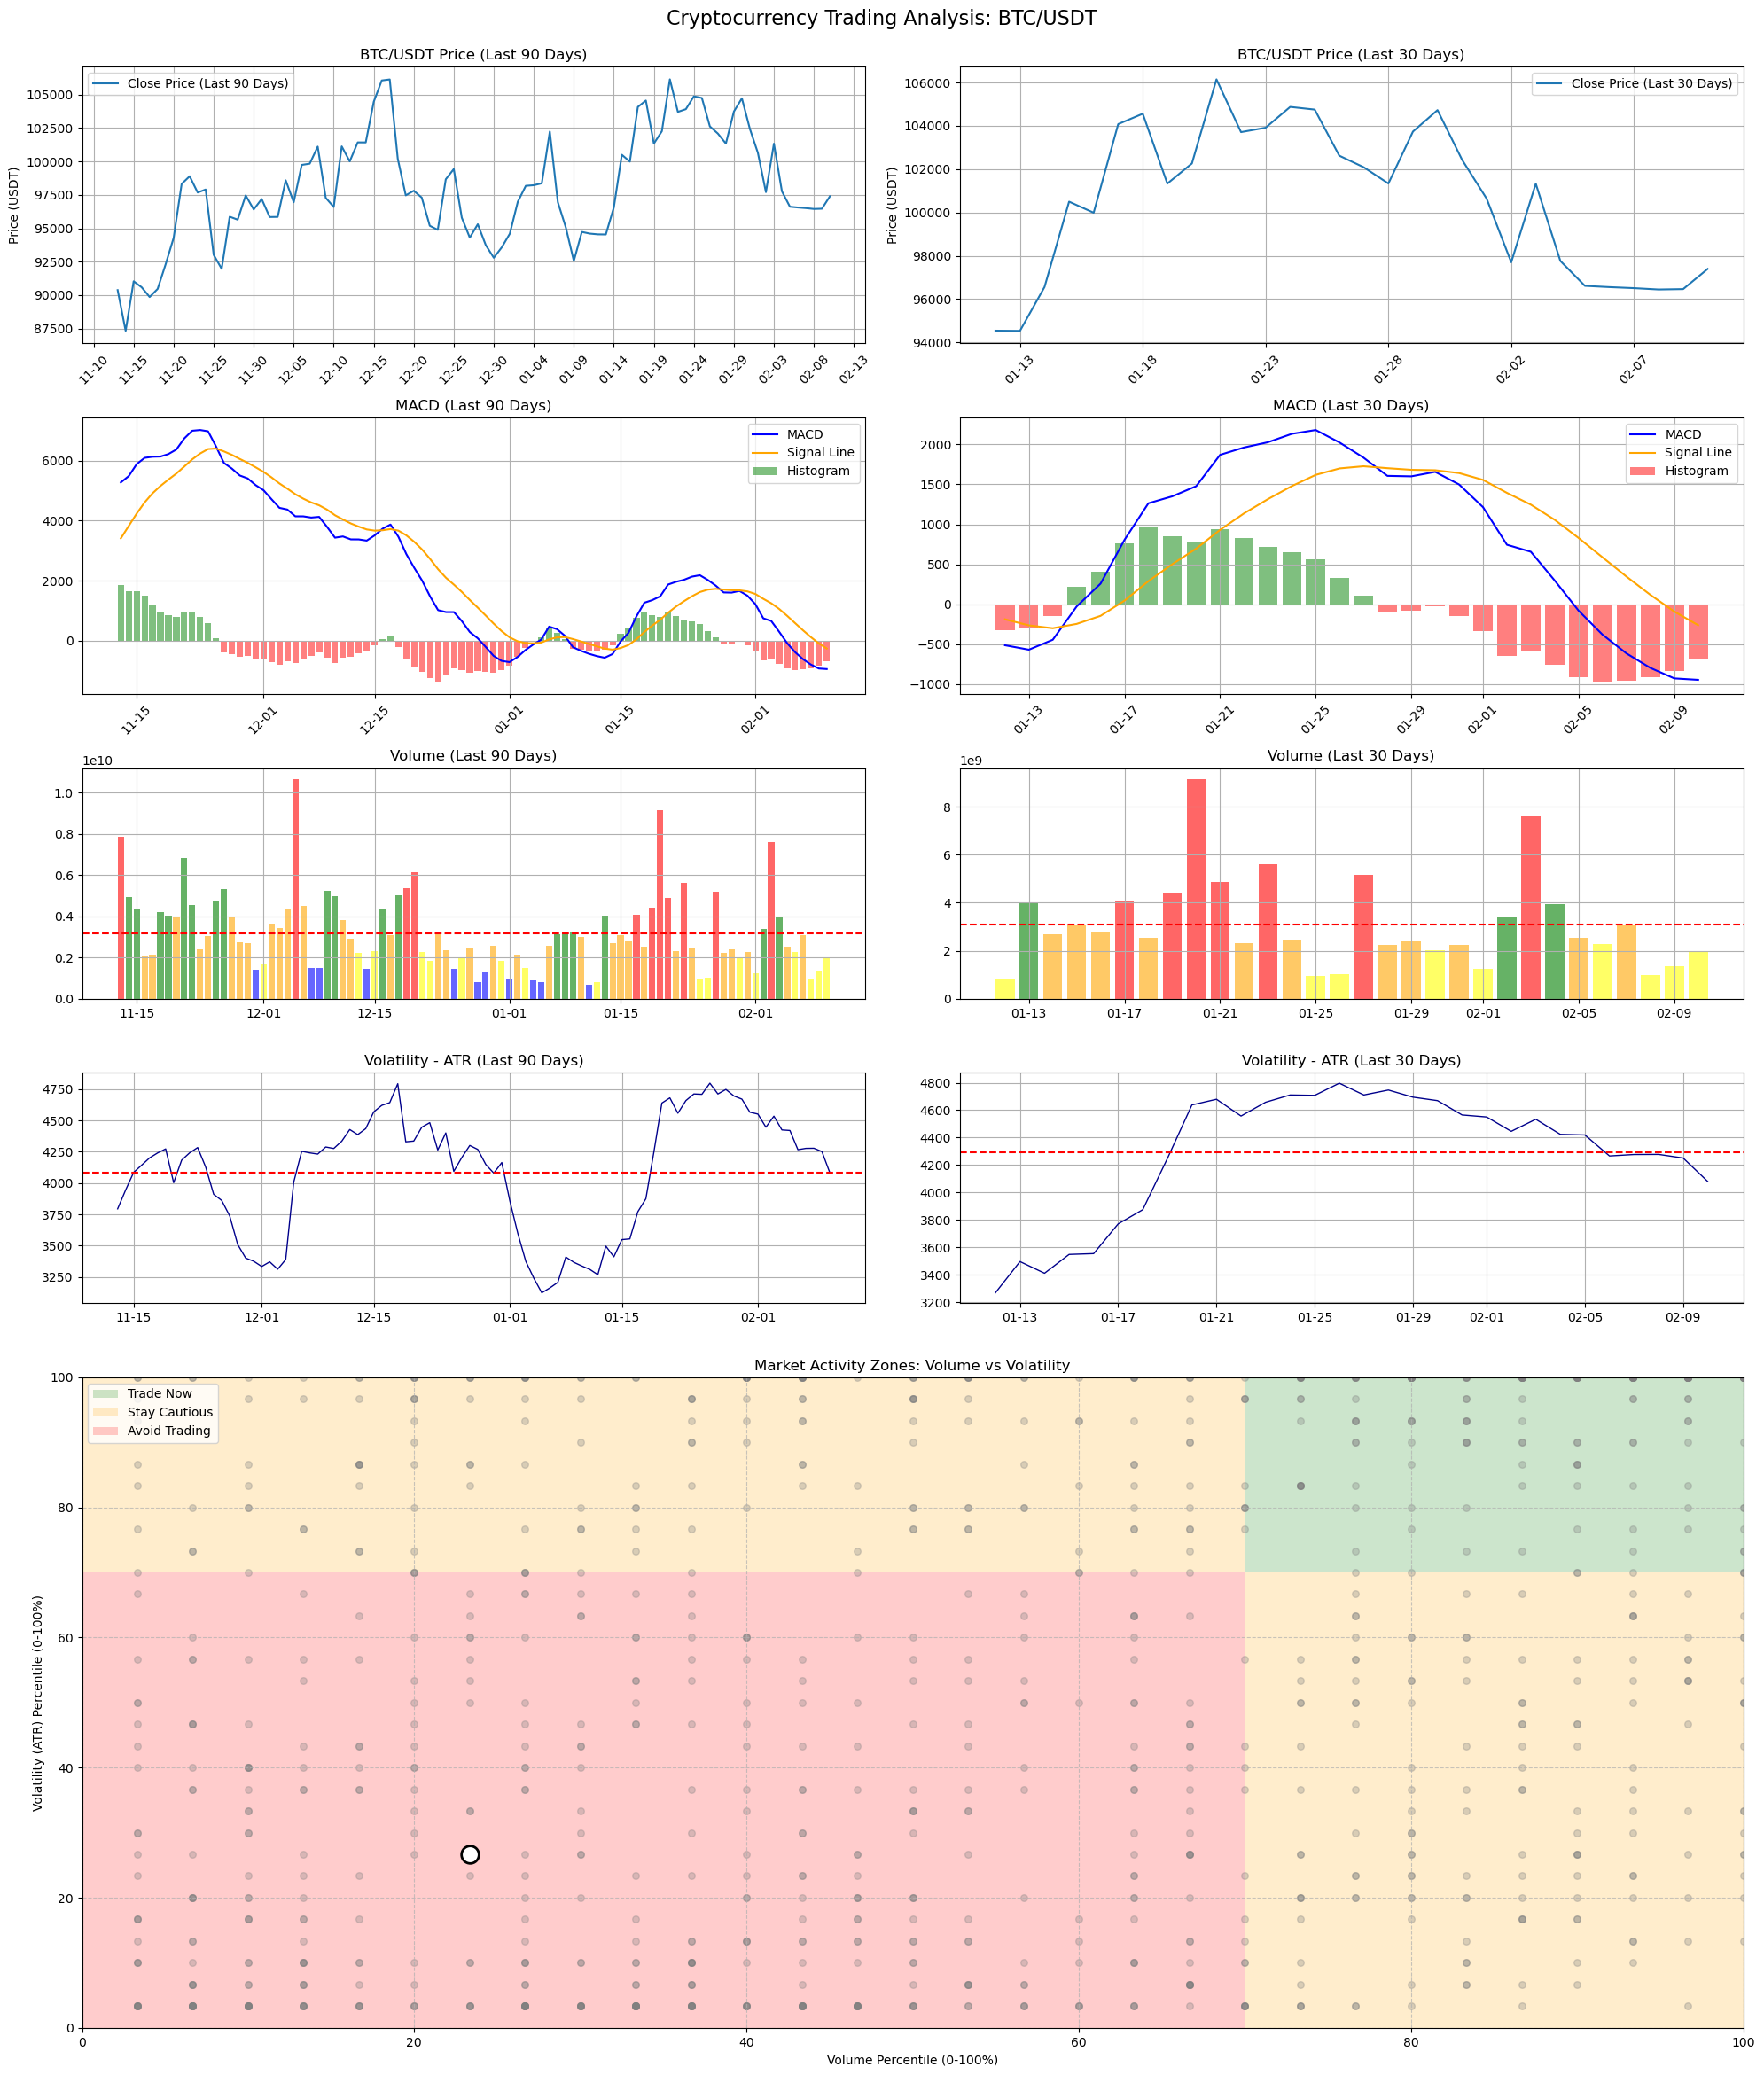

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import percentileofscore
from dataclasses import dataclass, field
from enum import Enum
from typing import List, Dict, Optional
from datetime import datetime, timedelta
import logging
import json
import os
from matplotlib.patches import Rectangle, Patch

# ================== SETUP ==================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the absolute path to config.json
CONFIG_PATH = r"C:\Users\drewr\OneDrive\Escritorio\Google Cloud Training\config.json"

# Load configuration from the JSON file
try:
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)
except FileNotFoundError:
    logging.error(f"config.json file not found at {CONFIG_PATH}. Please check the path.")
    exit(1)

LOOKBACK_DAYS = config.get("LOOKBACK_DAYS", 180)
MACD_PARAMS = config.get("MACD_PARAMS", (12, 26, 9))
TIMEZONE = 'UTC'

# ================== ENUMS ==================
class SignalType(Enum):
    LONG = 'LONG'
    SHORT = 'SHORT'
    EXIT = 'EXIT'
    NO_SIGNAL = 'NO_SIGNAL'

# ================== DATA CLASSES ==================
@dataclass
class TradingParams:
    MIN_TOTAL_SCORE: int = config.get("TradingParams", {}).get("MIN_TOTAL_SCORE", 4)
    MIN_VOLUME_PERCENTILE: float = config.get("TradingParams", {}).get("MIN_VOLUME_PERCENTILE", 30.0)
    MIN_VOLATILITY_PERCENTILE: float = config.get("TradingParams", {}).get("MIN_VOLATILITY_PERCENTILE", 30.0)
    BASE_RISK_PER_TRADE: float = config.get("TradingParams", {}).get("BASE_RISK_PER_TRADE", 0.02)
    MAX_RISK_PER_TRADE: float = config.get("TradingParams", {}).get("MAX_RISK_PER_TRADE", 0.05)
    ATR_MULTIPLIER_SL: float = config.get("TradingParams", {}).get("ATR_MULTIPLIER_SL", 1.5)
    TP_LEVELS: List[float] = field(default_factory=lambda: config.get("TradingParams", {}).get("TP_LEVELS", [1.5, 2.5, 3.5]))
    TP_SIZES: List[float] = field(default_factory=lambda: config.get("TradingParams", {}).get("TP_SIZES", [0.3, 0.3, 0.4]))
    MAX_HOLDING_DAYS: int = config.get("TradingParams", {}).get("MAX_HOLDING_DAYS", 10)
    MIN_HOLDING_HOURS: int = config.get("TradingParams", {}).get("MIN_HOLDING_HOURS", 4)

@dataclass
class TradeSignal:
    timestamp: datetime
    signal_type: SignalType
    entry_price: float
    stop_loss: float
    take_profits: List[float]
    position_size: float
    market_score: int
    market_condition: str
    risk_amount: float
    trade_id: str
    volume_percentile: float
    volatility_percentile: float
    macd_status: str
    atr: float

# ================== TRADING RULES ==================
class TradingRules:
    def __init__(self, params: TradingParams):
        self.params = params

    def calculate_position_size(self, account_size: float, entry_price: float, stop_loss: float, risk_percentage: float) -> float:
        risk_amount = account_size * risk_percentage
        risk_per_unit = abs(entry_price - stop_loss)
        return risk_amount / risk_per_unit if risk_per_unit != 0 else 0

    def calculate_stop_loss(self, entry_price: float, atr: float, signal_type: SignalType) -> float:
        if signal_type == SignalType.LONG:
            return entry_price - (atr * self.params.ATR_MULTIPLIER_SL)
        return entry_price + (atr * self.params.ATR_MULTIPLIER_SL)

    def calculate_take_profits(self, entry_price: float, stop_loss: float, signal_type: SignalType) -> List[float]:
        risk = abs(entry_price - stop_loss)
        if signal_type == SignalType.LONG:
            return [entry_price + (risk * r) for r in self.params.TP_LEVELS]
        return [entry_price - (risk * r) for r in self.params.TP_LEVELS]

class ModifiedTradingRules(TradingRules):
    def calculate_market_score(self, df: pd.DataFrame) -> int:
        current = df.iloc[-1]
        volume_score = 3 if current['volume_pct'] >= 70 else 2 if current['volume_pct'] >= 50 else 1 if current['volume_pct'] >= 30 else 0
        volatility_score = 3 if current['atr_pct'] >= 70 else 2 if current['atr_pct'] >= 50 else 1 if current['atr_pct'] >= 30 else 0
        macd_score = 2 if current['macd'] > current['signal'] else 0
        return volume_score + volatility_score + macd_score

    def generate_trade_signal(self, df: pd.DataFrame, account_size: float = 100000) -> Optional[TradeSignal]:
        current = df.iloc[-1]
        total_score = self.calculate_market_score(df)

        # Debug logging for signal conditions
        logging.info(f"\n=== Signal Check at {current.name} ===")
        logging.info(f"Current Price: {current['close']}")
        logging.info(f"Market Score Breakdown:")
        logging.info(f"- Base Score: {total_score}")
        logging.info(f"- Volume Percentile: {current['volume_pct']:.2f}% (min required: {self.params.MIN_VOLUME_PERCENTILE}%)")
        logging.info(f"- Volatility Percentile: {current['atr_pct']:.2f}% (min required: {self.params.MIN_VOLATILITY_PERCENTILE}%)")
        logging.info(f"- MACD Status: {'Bullish' if current['macd'] > current['signal'] else 'Bearish'}")

        # Check basic conditions and log why they fail
        if total_score < self.params.MIN_TOTAL_SCORE:
            logging.info(f"❌ Signal rejected: Total score {total_score} below minimum {self.params.MIN_TOTAL_SCORE}")
            return None
        if current['volume_pct'] < self.params.MIN_VOLUME_PERCENTILE:
            logging.info(f"❌ Signal rejected: Volume percentile too low")
            return None
        if current['atr_pct'] < self.params.MIN_VOLATILITY_PERCENTILE:
            logging.info(f"❌ Signal rejected: Volatility percentile too low")
            return None

        # Check breakout conditions
        levels = self.identify_breakout_levels(df)
        macd_bullish = current['macd'] > current['signal']
        
        logging.info(f"\nBreakout Levels:")
        logging.info(f"- Resistance: {levels['resistance']:.2f}")
        logging.info(f"- Support: {levels['support']:.2f}")
        logging.info(f"- Current Price: {current['close']:.2f}")

        signal_type = SignalType.LONG if current['close'] > levels['resistance'] and macd_bullish else \
                     SignalType.SHORT if current['close'] < levels['support'] and not macd_bullish else \
                     SignalType.NO_SIGNAL

        if signal_type == SignalType.NO_SIGNAL:
            logging.info("❌ Signal rejected: No breakout detected")
            return None

        # If we get here, we have a valid signal
        entry_price = current['close']
        stop_loss = self.calculate_stop_loss(entry_price, current['ATR'], signal_type)
        risk_percentage = self.adjust_risk_percentage(total_score)
        position_size = self.calculate_position_size(account_size, entry_price, stop_loss, risk_percentage)
        take_profits = self.calculate_take_profits(entry_price, stop_loss, signal_type)

        logging.info(f"\n✅ Valid {signal_type.value} Signal Generated!")
        logging.info(f"Entry Price: {entry_price:.2f}")
        logging.info(f"Stop Loss: {stop_loss:.2f}")
        logging.info(f"Take Profits: {[f'{tp:.2f}' for tp in take_profits]}")
        logging.info(f"Position Size: {position_size:.4f}")
        logging.info(f"Risk Percentage: {risk_percentage*100:.2f}%")

        return TradeSignal(
            timestamp=current.name,
            signal_type=signal_type,
            entry_price=entry_price,
            stop_loss=stop_loss,
            take_profits=take_profits,
            position_size=position_size,
            market_score=total_score,
            market_condition=self.classify_market_condition(current['volume_pct'], current['atr_pct']),
            risk_amount=account_size * risk_percentage,
            trade_id=f"{signal_type.value}_{current.name.strftime('%Y%m%d_%H%M')}",
            volume_percentile=current['volume_pct'],
            volatility_percentile=current['atr_pct'],
            macd_status='Bullish' if macd_bullish else 'Bearish',
            atr=current['ATR']
        )

    def adjust_risk_percentage(self, market_score: int) -> float:
        if market_score >= 6:
            return min(self.params.BASE_RISK_PER_TRADE * 1.2, self.params.MAX_RISK_PER_TRADE)
        elif market_score >= 4:
            return self.params.BASE_RISK_PER_TRADE
        else:
            return self.params.BASE_RISK_PER_TRADE * 0.8

    @staticmethod
    def identify_breakout_levels(df: pd.DataFrame, lookback: int = 20) -> Dict[str, float]:
        recent_data = df.tail(lookback)
        atr = recent_data['ATR'].iloc[-1]
        buffer = atr * 0.5
        return {
            'resistance': recent_data['high'].max() + buffer,
            'support': recent_data['low'].min() - buffer
        }

    @staticmethod
    def classify_market_condition(volume_pct: float, atr_pct: float) -> str:
        if volume_pct >= 70 and atr_pct >= 70:
            return "Strong Trend"
        elif volume_pct >= 50 and atr_pct >= 50:
            return "Moderate Trend"
        else:
            return "Weak Trend"

# ================== TRADE MANAGER ==================
class TradeManager:
    def __init__(self, trading_rules: ModifiedTradingRules):
        self.trading_rules = trading_rules
        self.active_trades: Dict[str, TradeSignal] = {}
        self.trade_history: List[Dict] = []

    def calculate_performance_metrics(self) -> Dict:
        """Calculate performance metrics from trade history."""
        if not self.trade_history:
            return {}

        trade_history_df = self.get_trade_history_df()
        total_pnl = trade_history_df['pnl'].sum()
        num_trades = len(trade_history_df)
        winning_trades = trade_history_df[trade_history_df['pnl'] > 0]
        win_rate = len(winning_trades) / num_trades if num_trades > 0 else 0
        avg_pnl_per_trade = total_pnl / num_trades if num_trades > 0 else 0
        avg_holding_period = (trade_history_df['exit_time'] - trade_history_df['entry_time']).mean()

        # Risk-adjusted metrics
        gross_profit = trade_history_df[trade_history_df['pnl'] > 0]['pnl'].sum()
        gross_loss = trade_history_df[trade_history_df['pnl'] < 0]['pnl'].sum()
        profit_factor = gross_profit / abs(gross_loss) if gross_loss != 0 else float('inf')

        # Drawdown
        trade_history_df['cumulative_pnl'] = trade_history_df['pnl'].cumsum()
        trade_history_df['peak'] = trade_history_df['cumulative_pnl'].cummax()
        trade_history_df['drawdown'] = trade_history_df['cumulative_pnl'] - trade_history_df['peak']
        max_drawdown = trade_history_df['drawdown'].min()

        return {
            'total_pnl': total_pnl,
            'num_trades': num_trades,
            'win_rate': win_rate,
            'avg_pnl_per_trade': avg_pnl_per_trade,
            'avg_holding_period': avg_holding_period,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'gross_profit': gross_profit,
            'gross_loss': gross_loss
        }

    def backtest(self, df: pd.DataFrame):
        """Backtest the strategy on historical data"""
        checks = 0
        signals_generated = 0
        
        for i in range(len(df)):
            checks += 1
            current_time = df.index[i]
            current_data = df.iloc[:i+1]
            self.update(current_data, current_time)
            if len(self.trade_history) > signals_generated:
                signals_generated += 1
        
        logging.info(f"\nBacktest Summary:")
        logging.info(f"Total periods checked: {checks}")
        logging.info(f"Signals generated: {signals_generated}")
        logging.info(f"Signal rate: {(signals_generated/checks)*100:.2f}%")

    def update(self, df: pd.DataFrame, current_time: datetime):
        """Update trade management system with new data"""
        self._check_exits(df, current_time)
        if len(self.active_trades) < 3:  # Maximum 3 concurrent trades
            signal = self.trading_rules.generate_trade_signal(df)
            if signal:
                self._process_new_signal(signal)
                logging.info(f"\nNew Trade Opened: {signal.trade_id}")

    def _check_exits(self, df: pd.DataFrame, current_time: datetime):
        """Check all active trades for exit signals"""
        current_price = df.iloc[-1]['close']
        for trade_id, trade in list(self.active_trades.items()):
            exit_signal = self._check_exit_conditions(df, trade, current_time, current_price)
            if exit_signal:
                self._close_trade(trade_id, current_price, current_time, exit_signal)

    def _check_exit_conditions(self, df: pd.DataFrame, trade: TradeSignal, current_time: datetime, current_price: float) -> Optional[str]:
        """Check various exit conditions"""
        if (trade.signal_type == SignalType.LONG and current_price <= trade.stop_loss or
            trade.signal_type == SignalType.SHORT and current_price >= trade.stop_loss):
            return "Stop Loss"
        for i, tp in enumerate(trade.take_profits):
            if (trade.signal_type == SignalType.LONG and current_price >= tp or
                trade.signal_type == SignalType.SHORT and current_price <= tp):
                return f"Take Profit {i+1}"
        if (current_time - trade.timestamp) > timedelta(days=self.trading_rules.params.MAX_HOLDING_DAYS):
            return "Max Hold Time"
        return None

    def _process_new_signal(self, signal: TradeSignal):
        """Process a new trade signal"""
        self.active_trades[signal.trade_id] = signal

    def _close_trade(self, trade_id: str, exit_price: float, exit_time: datetime, exit_reason: str):
        """Close a trade and record it in history"""
        trade = self.active_trades[trade_id]
        pnl = (exit_price - trade.entry_price) * trade.position_size if trade.signal_type == SignalType.LONG else (trade.entry_price - exit_price) * trade.position_size
        trade_record = {
            'trade_id': trade_id,
            'entry_time': trade.timestamp,
            'exit_time': exit_time,
            'signal_type': trade.signal_type.value,
            'entry_price': trade.entry_price,
            'exit_price': exit_price,
            'position_size': trade.position_size,
            'pnl': pnl,
            'exit_reason': exit_reason,
            'market_score': trade.market_score,
            'risk_amount': trade.risk_amount
        }
        self.trade_history.append(trade_record)
        del self.active_trades[trade_id]
        logging.info(f"\nTrade Closed: {trade_id}, P&L: ${pnl:.2f}, Reason: {exit_reason}")

    def get_trade_history_df(self) -> pd.DataFrame:
        """Get trade history as a DataFrame"""
        return pd.DataFrame(self.trade_history)

    def get_active_trades_df(self) -> pd.DataFrame:
        """Get active trades as a DataFrame"""
        if not self.active_trades:
            return pd.DataFrame()
        return pd.DataFrame([
            {
                'trade_id': t.trade_id,
                'signal_type': t.signal_type.value,
                'entry_price': t.entry_price,
                'current_stop': t.stop_loss,
                'position_size': t.position_size,
                'market_score': t.market_score,
                'age_days': (datetime.now() - t.timestamp).days
            }
            for t in self.active_trades.values()
        ])

# ================== DATA FETCHING ==================
def fetch_data(symbol: str, timeframe: str = '1d', since: Optional[int] = None, limit: int = 1000) -> pd.DataFrame:
    """Fetch OHLCV data from Binance"""
    exchange = ccxt.binance()
    try:
        data = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
    except (ccxt.NetworkError, ccxt.ExchangeError) as e:
        logging.error(f"Error fetching data: {e}")
        return None

    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    df.set_index('timestamp', inplace=True)

    # Calculate technical indicators
    df['volume_usd'] = df['volume'] * df['close']
    ema_fast = df['close'].ewm(span=MACD_PARAMS[0], adjust=False).mean()
    ema_slow = df['close'].ewm(span=MACD_PARAMS[1], adjust=False).mean()
    df['macd'] = ema_fast - ema_slow
    df['signal'] = df['macd'].ewm(span=MACD_PARAMS[2], adjust=False).mean()
    df['histogram'] = df['macd'] - df['signal']
    df['prev_close'] = df['close'].shift(1)
    df['TR'] = np.maximum(df['high'] - df['low'], np.maximum(abs(df['high'] - df['prev_close']), abs(df['low'] - df['prev_close'])))
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df.drop('prev_close', axis=1, inplace=True)
    df['volume_pct'] = df['volume_usd'].rolling(30).apply(lambda x: percentileofscore(x, x[-1]))
    df['atr_pct'] = df['ATR'].rolling(30).apply(lambda x: percentileofscore(x, x[-1]))

    return df

# ================== VISUALIZATION ==================

def plot_equity_curve(trade_history_df: pd.DataFrame, ax: plt.Axes):
    """Plot the equity curve."""
    trade_history_df['cumulative_pnl'] = trade_history_df['pnl'].cumsum()
    ax.plot(trade_history_df['exit_time'], trade_history_df['cumulative_pnl'], label='Equity Curve', color='blue')
    ax.set_title('Equity Curve')
    ax.set_xlabel('Time')
    ax.set_ylabel('Cumulative PnL')
    ax.grid(True)
    ax.legend()

def plot_trade_distribution(trade_history_df: pd.DataFrame, ax: plt.Axes):
    """Plot the distribution of trade outcomes."""
    ax.hist(trade_history_df['pnl'], bins=30, color='blue', alpha=0.7, label='Trade PnL Distribution')
    ax.axvline(0, color='red', linestyle='--', label='Break-even')
    ax.set_title('Trade PnL Distribution')
    ax.set_xlabel('PnL')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.legend()

def plot_price(df, period: int, ax: plt.Axes):
    """Plot price data."""
    recent_data = df.tail(period)
    ax.plot(recent_data.index, recent_data['close'], label=f'Close Price (Last {period} Days)')
    ax.set_xlabel('')
    ax.set_ylabel('Price (USDT)')
    ax.set_title(f'BTC/USDT Price (Last {period} Days)')
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

def plot_macd(df: pd.DataFrame, period: int, ax: plt.Axes):
    """Plot MACD data"""
    recent_data = df.tail(period)
    ax.plot(recent_data.index, recent_data['macd'], label='MACD', color='blue')
    ax.plot(recent_data.index, recent_data['signal'], label='Signal Line', color='orange')
    colors = np.where(recent_data['histogram'] >= 0, 'green', 'red')
    ax.bar(recent_data.index, recent_data['histogram'], color=colors, alpha=0.5, label='Histogram')
    ax.set_title(f'MACD (Last {period} Days)')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)

def plot_volume_bar(df: pd.DataFrame, period: int, ax: plt.Axes):
    """Plot volume data with dynamic colors based on volume percentile."""
    recent_data = df.tail(period)
    colors = recent_data['volume_pct'].apply(lambda x: classify_volume_dynamic(x)[1])
    ax.bar(recent_data.index, recent_data['volume_usd'], color=colors, alpha=0.6)
    ax.axhline(recent_data['volume_usd'].mean(), color='red', linestyle='--', label=f'Avg Volume ({period} Days)')
    ax.set_title(f'Volume (Last {period} Days)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.grid(True)

def plot_volatility(df: pd.DataFrame, period: int, ax: plt.Axes):
    """Plot volatility (ATR) data"""
    recent_data = df.tail(period)
    ax.plot(recent_data.index, recent_data['ATR'], color='darkblue', lw=1)
    ax.axhline(recent_data['ATR'].mean(), color='red', linestyle='--', label=f'Avg ATR ({period} Days)')
    ax.set_title(f'Volatility - ATR (Last {period} Days)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.grid(True)

def plot_volume_volatility_scatter(df: pd.DataFrame, ax: plt.Axes):
    """Plot volume vs volatility scatterplot"""
    clean_df = df[['volume_pct', 'atr_pct']].copy().dropna()
    if len(clean_df) < 10:
        ax.text(0.5, 0.5, 'Insufficient Data', ha='center', va='center', fontsize=12)
        ax.set_title("Volume vs Volatility Scatterplot")
        return
    ax.add_patch(Rectangle((70, 70), 30, 30, facecolor='green', alpha=0.2, label='Trade Now: High Volume & Volatility'))
    ax.add_patch(Rectangle((0, 70), 70, 30, facecolor='orange', alpha=0.2, label='Stay Cautious: Mixed Signals'))
    ax.add_patch(Rectangle((70, 0), 30, 70, facecolor='orange', alpha=0.2))
    ax.add_patch(Rectangle((0, 0), 70, 70, facecolor='red', alpha=0.2, label='Avoid Trading: Low Activity'))
    ax.scatter(clean_df['volume_pct'], clean_df['atr_pct'], c='gray', alpha=0.3, s=30)
    today = clean_df.iloc[-1]
    ax.scatter(today['volume_pct'], today['atr_pct'], c='white', s=200, edgecolor='black', linewidth=2, label="Today's Position", zorder=10)
    ax.set_title("Market Activity Zones: Volume vs Volatility")
    ax.set_xlabel("Volume Percentile (0-100%)")
    ax.set_ylabel("Volatility (ATR) Percentile (0-100%)")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.7)
    legend_elements = [
        Patch(facecolor='green', alpha=0.2, label='Trade Now'),
        Patch(facecolor='orange', alpha=0.2, label='Stay Cautious'),
        Patch(facecolor='red', alpha=0.2, label='Avoid Trading')
    ]
    ax.legend(handles=legend_elements, loc='upper left')

# ================== MARKET STATE MESSAGE ==================
def generate_market_state_message(df):
    """Generates final trading recommendation with scoring breakdown."""
    today = df.iloc[-1]
    volume_pct = today['volume_pct']
    atr_pct = today['atr_pct']
    macd_bullish = today['macd'] > today['signal']

    # Scoring System
    def get_score(value, rules):
        for threshold, score in rules:
            if value >= threshold:
                return score
        return 0

    volume_score = get_score(volume_pct, [(90, 3), (70, 2), (30, 1), (0, 0)])
    volatility_score = get_score(atr_pct, [(90, 3), (70, 2), (30, 1), (0, 0)])
    macd_score = 1 if macd_bullish else 0
    total_score = volume_score + volatility_score + macd_score

    # Determine recommendation
    if total_score >= 6:
        state = "TRADE NOW"
        confidence = "High Confidence"
        reason = "Strong momentum: high volume + high volatility + bullish MACD"
    elif total_score >= 4:
        state = "STAY CAUTIOUS"
        confidence = "Medium Confidence"
        reason = "Moderate momentum: potential opportunities"
    else:
        state = "AVOID TRADING"
        confidence = "Low Confidence"
        reason = "Low momentum: choppy market conditions"

    # Generate output
    message = (
        f"=== MARKET STATUS ===\n"
        f"Recommendation: {state} ({confidence})\n"
        f"Reason: {reason}\n\n"
        f"=== CURRENT METRICS ===\n"
        f"- Volume Percentile: {volume_pct:.1f}% ({classify_volume_dynamic(volume_pct)[0]})\n"
        f"- Volatility Percentile: {atr_pct:.1f}% ({classify_volatility(atr_pct)[0]})\n"
        f"- MACD Status: {'Bullish' if macd_bullish else 'Bearish'}\n"
        f"- Trade Score: {total_score}/7\n\n"
        f"=== SCORING BREAKDOWN ===\n"
        f"| Metric          | Percentile | Score |\n"
        f"|-----------------|------------|-------|\n"
        f"| Volume          | {volume_pct:.1f}%      | {volume_score}     |\n"
        f"| Volatility      | {atr_pct:.1f}%      | {volatility_score}     |\n"
        f"| MACD            | {'Bullish' if macd_bullish else 'Bearish'}    | {macd_score}     |\n"
        f"| **Total Score** |            | **{total_score}** |\n\n"
        f"=== ACTIONABLE RULES ===\n"
        f"- 6-7 Points: Strong momentum → TRADE NOW\n"
        f"- 4-5 Points: Moderate momentum → STAY CAUTIOUS\n"
        f"- 0-3 Points: Low momentum → AVOID TRADING"
    )
    return message

def classify_volume_dynamic(volume_pct):
    """Classifies volume based on dynamic percentiles."""
    if volume_pct <= 10:
        return "Very Low", 'blue', 'Very Low interest'
    elif 10 < volume_pct <= 30:
        return "Low", 'yellow', 'Low interest'
    elif 30 < volume_pct <= 70:
        return "Moderate", 'orange', 'Moderate interest'
    elif 70 < volume_pct <= 90:
        return "High", 'green', 'High interest'
    else:
        return "Very High", 'red', 'Very High interest'

def classify_volatility(atr_pct):
    """Classifies volatility based on dynamic percentiles."""
    if atr_pct <= 10:
        return "Very Low", 'blue', 'Calm market'
    elif 10 < atr_pct <= 30:
        return "Low", 'cyan', 'Stable conditions'
    elif 30 < atr_pct <= 70:
        return "Moderate", 'orange', 'Active market'
    elif 70 < atr_pct <= 90:
        return "High", 'red', 'Volatile! Caution'
    else:
        return "Extreme", 'purple', 'High risk!'

# ================== MAIN FUNCTION ==================
def main():
    symbol = 'BTC/USDT'
    timeframe = '1d'
    account_size = 100000

    # Initialize components
    trading_params = TradingParams()
    trading_rules = ModifiedTradingRules(trading_params)
    trade_manager = TradeManager(trading_rules)

    # Fetch and process data
    df = fetch_data(symbol, timeframe)
    if df is not None:
        # Backtest the strategy
        trade_manager.backtest(df)

        # Print results
        active_trades_df = trade_manager.get_active_trades_df()
        if not active_trades_df.empty:
            logging.info("\nActive Trades:")
            logging.info(active_trades_df)

        trade_history_df = trade_manager.get_trade_history_df()
        if not trade_history_df.empty:
            logging.info("\nTrade History:")
            logging.info(trade_history_df)

            # Calculate and log performance metrics
            performance_metrics = trade_manager.calculate_performance_metrics()
            logging.info("\nPerformance Metrics:")
            for metric, value in performance_metrics.items():
                logging.info(f"{metric}: {value}")

        # Generate and print market state message
        market_state_message = generate_market_state_message(df)
        logging.info("\n" + market_state_message)

        # Visualize data
        fig = plt.figure(figsize=(20, 30))
        gs = fig.add_gridspec(8, 2, height_ratios=[1.2, 1.2, 1, 1, 1.5, 1, 1, 0.5])
        ax_price90 = fig.add_subplot(gs[0, 0])
        ax_price30 = fig.add_subplot(gs[0, 1])
        plot_price(df, 90, ax_price90)
        plot_price(df, 30, ax_price30)
        ax_macd90 = fig.add_subplot(gs[1, 0])
        ax_macd30 = fig.add_subplot(gs[1, 1])
        plot_macd(df, 90, ax_macd90)
        plot_macd(df, 30, ax_macd30)
        ax_vol90 = fig.add_subplot(gs[2, 0])
        ax_vol30 = fig.add_subplot(gs[2, 1])
        plot_volume_bar(df, 90, ax_vol90)
        plot_volume_bar(df, 30, ax_vol30)
        ax_atr90 = fig.add_subplot(gs[3, 0])
        ax_atr30 = fig.add_subplot(gs[3, 1])
        plot_volatility(df, 90, ax_atr90)
        plot_volatility(df, 30, ax_atr30)
        ax_scatter = fig.add_subplot(gs[4:6, :])
        plot_volume_volatility_scatter(df, ax_scatter)

        # Add performance visualizations
        if not trade_history_df.empty:
            ax_equity = fig.add_subplot(gs[6, :])
            plot_equity_curve(trade_history_df, ax_equity)
            ax_distribution = fig.add_subplot(gs[7, :])
            plot_trade_distribution(trade_history_df, ax_distribution)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.suptitle(f'Cryptocurrency Trading Analysis: {symbol}', fontsize=16)
        plt.savefig('crypto_trading_analysis.png', dpi=300, bbox_inches='tight')
        logging.info("Analysis complete. Dashboard saved as crypto_trading_analysis.png")

if __name__ == "__main__":
    main()